# ミリオンライブ！架空のMTXシリーズ組み合わせ最適化

## 必要なモジュールの読み込み、設定

In [1]:
import json
import copy
import pandas as pd

import numpy as np
import scipy.special
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib
import seaborn as sns

import pprint
from IPython.core.display import display

# ランダムシードの固定
np.random.seed(4)
random.seed(4)

## データの読み込み

### 過去のCDシリーズデータの読み込み、表示、不正チェック

#### 読み込み、表示

In [2]:
# ファイル名
str_cd_series_json_name = '../data/ml_cd_series_data_20220529.json'

# 読み込み
with open(str_cd_series_json_name) as f:
    ml_data = json.load(f)

# データの表示（表示上曲名が分割されて表示されている箇所があるが、データは問題ない）
pprint.pprint(ml_data, sort_dicts=False)

{'series_list': [{'series_name': 'LIVE THE@TER PERFORMANCE',
                  'series_abbr': 'LTP',
                  'start_date': '20130424',
                  'disc_list': [{'disc_number': '02',
                                 'disc_member_list': ['haruka',
                                                      'tomoka',
                                                      'yuriko',
                                                      'serika',
                                                      'shizuka'],
                                 'group_list': [{'group_type': 'unit',
                                                 'group_name': None,
                                                 'group_song_list': ['Legend '
                                                                     'Girls!!'],
                                                 'group_member_list': ['haruka',
                                                                       'tomoka',
                 

#### 不正チェック

In [3]:
# ユニークなメンバーのリスト
list_unique_member = []

# disc_member_listに含まれているメンバーのユニーク数が52であることを確認
for one_series in ml_data['series_list']:
    for one_disc in one_series['disc_list']:
        for one_disc_member in one_disc['disc_member_list']:
            if one_disc_member not in list_unique_member:
                list_unique_member.append(one_disc_member)
                
print('# CDシリーズに参加メンバーのユニーク数: {0}'.format(len(list_unique_member)))
print('# メンバー（ユニーク値）')
print(list_unique_member)


# group_member_listに入っていて、そのdiscのdisc_member_listに入っていないメンバーがいないかを確認
incomplete_data_flag = 0
for one_series in ml_data['series_list']:
    for one_disc in one_series['disc_list']:
        for one_group in one_disc['group_list']:
            if len(set(one_group['group_member_list']) - set(one_disc['disc_member_list'])) != 0:
                print('# データ不正：{0}'.format(one_group))
                incomplete_data_flag += 1

print('# データの不正箇所数: {}'.format(incomplete_data_flag))

# CDシリーズに参加メンバーのユニーク数: 52
# メンバー（ユニーク値）
['haruka', 'tomoka', 'yuriko', 'serika', 'shizuka', 'hibiki', 'mirai', 'fuka', 'anna', 'nao', 'chihaya', 'shiho', 'kotoha', 'megumi', 'iori', 'emily', 'rio', 'mizuki', 'miki', 'tsubasa', 'reika', 'julia', 'azusa', 'karen', 'sayoko', 'noriko', 'yayoi', 'tamaki', 'iku', 'kana', 'ritsuko', 'hinata', 'minako', 'arisa', 'takane', 'umi', 'matsuri', 'miya', 'makoto', 'mami', 'elena', 'ayumu', 'yukiho', 'momoko', 'chizuru', 'roco', 'ami', 'subaru', 'akane', 'konomi', 'tsumugi', 'kaori']
# データの不正箇所数: 0


### 名前の対応表の読み込み、表示

In [4]:
# name（ローマ字表記）と氏名（漢字表記）の対応表のファイル名
str_name_csv = '../data/ml_name.csv'

# 読み込み
sr_name = pd.read_csv(str_name_csv, squeeze=True, header=None, index_col=0)

# 辞書に変換
dict_name = dict(zip(sr_name.index, sr_name))
print('# 名前の辞書')
print(dict_name)

# nameのリスト
list_name = list(dict_name.keys())

# ASの人数
n_as_member = 13

# ミリオンスターズのみのnameのリスト
list_ms_name = list_name[n_as_member:]
print('# ミリオンスターズのリスト')
print(list_ms_name)

# 名前の辞書
{'haruka': '天海春香', 'chihaya': '如月千早', 'miki': '星井美希', 'yukiho': '萩原雪歩', 'yayoi': '高槻やよい', 'makoto': '菊地真', 'iori': '水瀬伊織', 'takane': '四条貴音', 'ritsuko': '秋月律子', 'azusa': '三浦あずさ', 'ami': '双海亜美', 'mami': '双海真美', 'hibiki': '我那覇響', 'mirai': '春日未来', 'shizuka': '最上静香', 'tsubasa': '伊吹翼', 'kotoha': '田中琴葉', 'elena': '島原エレナ', 'minako': '佐竹美奈子', 'megumi': '所恵美', 'matsuri': '徳川まつり', 'serika': '箱崎星梨花', 'akane': '野々原茜', 'anna': '望月杏奈', 'roco': 'ロコ', 'yuriko': '七尾百合子', 'sayoko': '高山紗代子', 'arisa': '松田亜利沙', 'umi': '高坂海美', 'iku': '中谷育', 'tomoka': '天空橋朋花', 'emily': 'エミリー', 'shiho': '北沢志保', 'ayumu': '舞浜歩', 'hinata': '木下ひなた', 'kana': '矢吹可奈', 'nao': '横山奈緒', 'chizuru': '二階堂千鶴', 'konomi': '馬場このみ', 'tamaki': '大神環', 'fuka': '豊川風花', 'miya': '宮尾美也', 'noriko': '福田のり子', 'mizuki': '真壁瑞希', 'karen': '篠宮可憐', 'rio': '百瀬莉緒', 'subaru': '永吉昴', 'reika': '北上麗花', 'momoko': '周防桃子', 'julia': 'ジュリア', 'tsumugi': '白石紬', 'kaori': '桜守歌織'}
# ミリオンスターズのリスト
['mirai', 'shizuka', 'tsubasa', 'kotoha', 'elena', 'minako', 'megumi', 'm

ミリオンスターズ39人を、なるべく新鮮な組み合わせを目指してユニットに分ける。

「新鮮な組み合わせ」とは、後述する「関係評価値」と「過去ユニット人数評価値」から決定する、「組み合わせ評価値」が低い組み合わせを指す。

作成する組み合わせは、MTG, MTWに倣い、以下の通りとする。
- 2人ユニット：3つ
- 3人ユニット：4つ
- 4人ユニット：4つ
- 5人ユニット：1つ

In [5]:
# 作るn人組ユニットの数の辞書
dict_ms_unit_num = {
    2: 3,
    3: 4,
    4: 4,
    5: 1
}

# 上記の合計が39であることを確認
n_all_ms = 0
for n_member, n_unit in dict_ms_unit_num.items():
    n_all_ms += n_member * n_unit
print('# MTXシリーズ合計人数:', n_all_ms)

# MTXシリーズ合計人数: 39


## メンバー間の「関係評価値」の定義
任意の2人の「関係評価値」を定義する。

関係評価値は加点方式。大まかな説明は以下の通り。
1. 同一のCDに互いの歌唱曲が含まれている場合に加点
1. 同一のグループとして楽曲を歌唱している場合に加点
    1. より新しいCDシリーズにおけるグループであるほど大きく加点
    1. グループの形態により異なる係数をかけて加点
    1. グループに固有の名称が設定されている場合はそうでない場合よりも大きく加点
    1. グループの人数が少ないほど大きく加点
    1. グループの楽曲数が多いほど大きく加点


### 1. 同一のCDに互いの歌唱曲が含まれている場合の係数の設定

In [6]:
c_same_disc_member = 2.0

### 2-1. 各CDシリーズの重み係数の設定
新しいCDシリーズほど、重みを大きく設定する。

具体的には、n番目(n=1, 2, ...)に新しいCDシリーズの重みを*0.99^(n-1)とする。

新旧の比較には、各シリーズの1枚目の発売日を基準として用いる。

In [7]:
# シリーズ数の取得
n_series = len(ml_data['series_list'])

# 各シリーズに対する重みを記録する辞書
## キーをシリーズ略称、値を重みとする。
dict_time_weight = {}

for i, one_series in enumerate(ml_data['series_list']):
    # 今回用いているデータは時系列順になっている
    dict_time_weight[one_series['series_abbr']] = 0.99 ** (n_series - i - 1)

pprint.pprint(dict_time_weight, sort_dicts=False)

{'LTP': 0.8775210229989678,
 'LTH': 0.8863848717161292,
 'LTD': 0.8953382542587164,
 'LTF': 0.9043820750088044,
 'TA': 0.9135172474836408,
 'MTG': 0.9227446944279201,
 'MS': 0.9320653479069899,
 'TB': 0.941480149401,
 'MTW': 0.9509900498999999,
 'TC': 0.96059601,
 'なん笑': 0.970299,
 'VOY@GER': 0.9801,
 'MTS': 0.99,
 'ミリ女': 1.0}


### 2-2. グループの形態による重みの設定

グループの形態は、'group', 'team', 'unit'の3パターン（ランティス公式サイトの記載を参照）。それぞれの形態に対して重みを設定する。

In [8]:
dict_group_type_weight = {
    'group': 20,
    'team': 20,
    'unit': 100
}

### 2-3. グループの固有の名称の有無に関する係数の設定
group_nameは、設定されている場合はtypeがstr、されていない場合はNoneTypeとなる。それぞれに係数を設定する。

In [9]:
dict_group_name_weight = {
    'str': 1.0,
    'NoneType': 0.9
}

# グループ名の設定の有無に応じた重み係数を出力する関数
def func_group_name_weight(group_name):
    return dict_group_name_weight[group_name.__class__.__name__]

### 2-4. グループの人数に関する重み係数の設定
少人数のグループで一緒に属しているほど大きい係数とする。具体的には、グループの人数の平方根の逆数を係数とする。

In [10]:
# グループのメンバー数を入力すると、重み係数を出力する関数
def func_n_member_weight(n_member):
    return 1 / np.sqrt(n_member)

### 2-5. グループの楽曲数に関する重み係数の設定
グループの楽曲数が多い程大きい係数とする。具体的には、楽曲数の平方根を係数とする。

In [11]:
# グループの楽曲数数を入力すると、重み係数を出力する関数
def func_n_song_weight(n_song):
    return np.sqrt(n_song)

### その他、必要な関数

In [12]:
# あるリストに要素AとBの両方が含まれている場合1、そうでない場合0を出力する関数
def func_flag_both_in(obj_A, obj_B, list_to_be_checked):
    if (obj_A in list_to_be_checked) & (obj_B in list_to_be_checked):
        flag = 1
    else:
        flag = 0
    return flag

### 関係評価値集計の実行

In [13]:
# 算出された関係評価値を記録する辞書
## 各シリーズに起因する評価値と、その合計
dict_eval_two_comb = {}

# ヒートマップ作成用に、合計のみの辞書も作成
dict_eval_sum_only = {}

# 着目するメンバーAに関するループ
for one_member_A in list_name:
    dict_eval_two_comb[one_member_A] = {}
    dict_eval_sum_only[one_member_A] = {}
    # 着目するメンバーBに関するループ
    for one_member_B in list_name:
        # 合計の初期化
        dict_eval_two_comb[one_member_A][one_member_B] = {'sum': 0}
        dict_eval_sum_only[one_member_A][one_member_B] = 0
        
        # 着目するシリーズに関するループ
        for one_series in ml_data['series_list']:
            # AとBの着目しているシリーズに対する評価値の初期化
            dict_eval_two_comb[one_member_A][one_member_B][one_series['series_abbr']] = 0

            # 着目するCDに関するループ
            for i, one_disc in enumerate(one_series['disc_list']):

                # AとBがどちらもこのCDのメンバーだったら加点
                dict_eval_two_comb[one_member_A][one_member_B][one_series['series_abbr']] \
                    += c_same_disc_member * func_flag_both_in(one_member_A, one_member_B, one_disc['disc_member_list'])
                
                # 着目するグループに関するループ
                for i, one_group in enumerate(one_disc['group_list']):
                    # AとBがどちらもこのグループのメンバーだったら加点
                    dict_eval_two_comb[one_member_A][one_member_B][one_series['series_abbr']] \
                        += func_flag_both_in(one_member_A, one_member_B, one_group['group_member_list']) \
                            * dict_group_type_weight[one_group['group_type']] \
                            * func_n_member_weight(len(one_group['group_member_list'])) \
                            * func_n_song_weight(len(one_group['group_song_list'])) \
                            * func_group_name_weight(one_group['group_name'])

            # シリーズの重みをシリーズの加点合計値に掛ける
            dict_eval_two_comb[one_member_A][one_member_B][one_series['series_abbr']] \
                *= dict_time_weight[one_series['series_abbr']]

            # 関係評価値に加える
            dict_eval_two_comb[one_member_A][one_member_B]['sum'] \
                 += dict_eval_two_comb[one_member_A][one_member_B][one_series['series_abbr']]
            
        # ヒートマップ作成用データにも転載
        dict_eval_sum_only[one_member_A][one_member_B] = dict_eval_two_comb[one_member_A][one_member_B]['sum']
        # ヒートマップ作成用データでは、自身との評価値はnp.nanとする（数値を空欄とするため）
        if one_member_A == one_member_B:
            dict_eval_sum_only[one_member_A][one_member_B] = np.nan

### 関係評価値の可視化

#### ミリオンスターズ39人分のヒートマップ

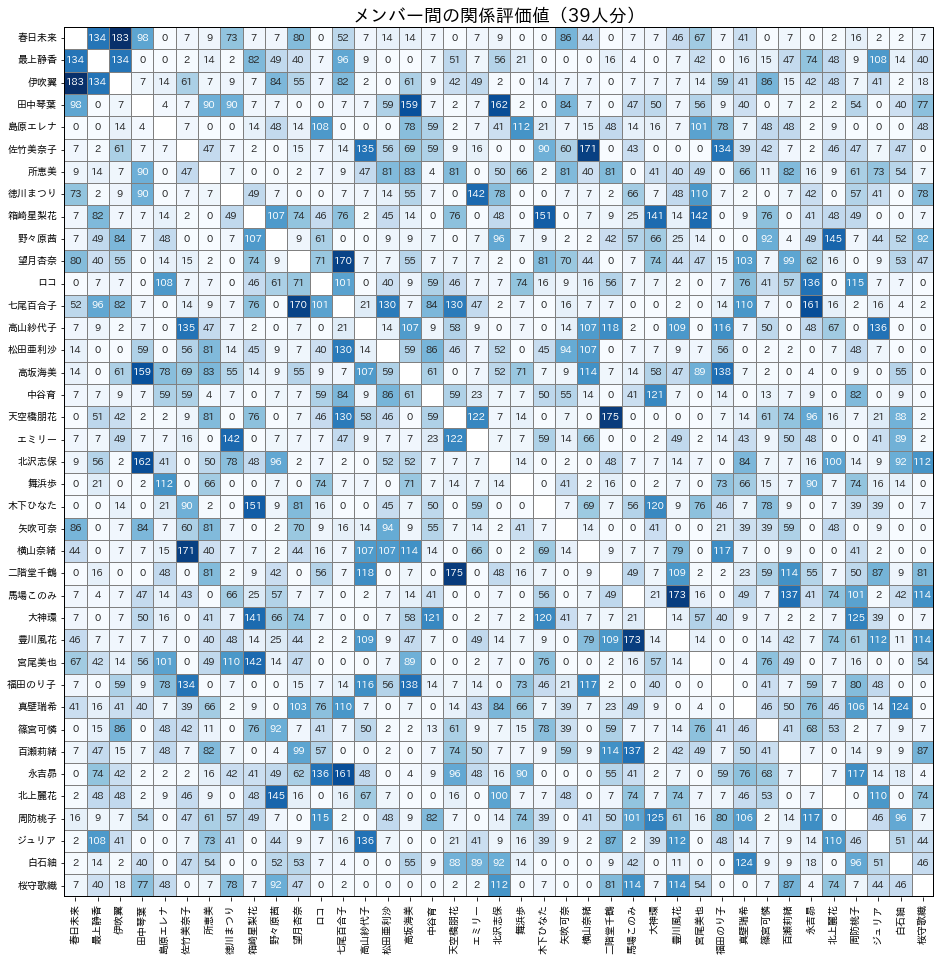

In [14]:
# 関係評価値のDataFrame化
df_eval = pd.DataFrame.from_dict(dict_eval_sum_only)

# ミリオンスターズ部分のDataFrame
df_eval_ms = df_eval.iloc[n_as_member:, n_as_member:].copy()
# 行・列名を日本語化したDataFrame
df_eval_ms_j = df_eval_ms.rename(columns=dict_name, index=dict_name)

# 作図の設定
fig, axes = plt.subplots(figsize=(16, 16))
fig.patch.set_facecolor('white')
sns.heatmap(df_eval_ms_j, annot=True, fmt='.0f', cmap='Blues',linewidths=.5, linecolor="gray", cbar=False, square=True, ax=axes)
axes.set_title('メンバー間の関係評価値（39人分）', fontsize=18)
axes.axhline(y=0, color='k',linewidth=2)
axes.axhline(y=df_eval_ms.shape[1], color='k',linewidth=2)
axes.axvline(x=0, color='k',linewidth=2)
axes.axvline(x=df_eval_ms.shape[1], color='k',linewidth=2)

#### ASとミリオンスターズ52人分のヒートマップ

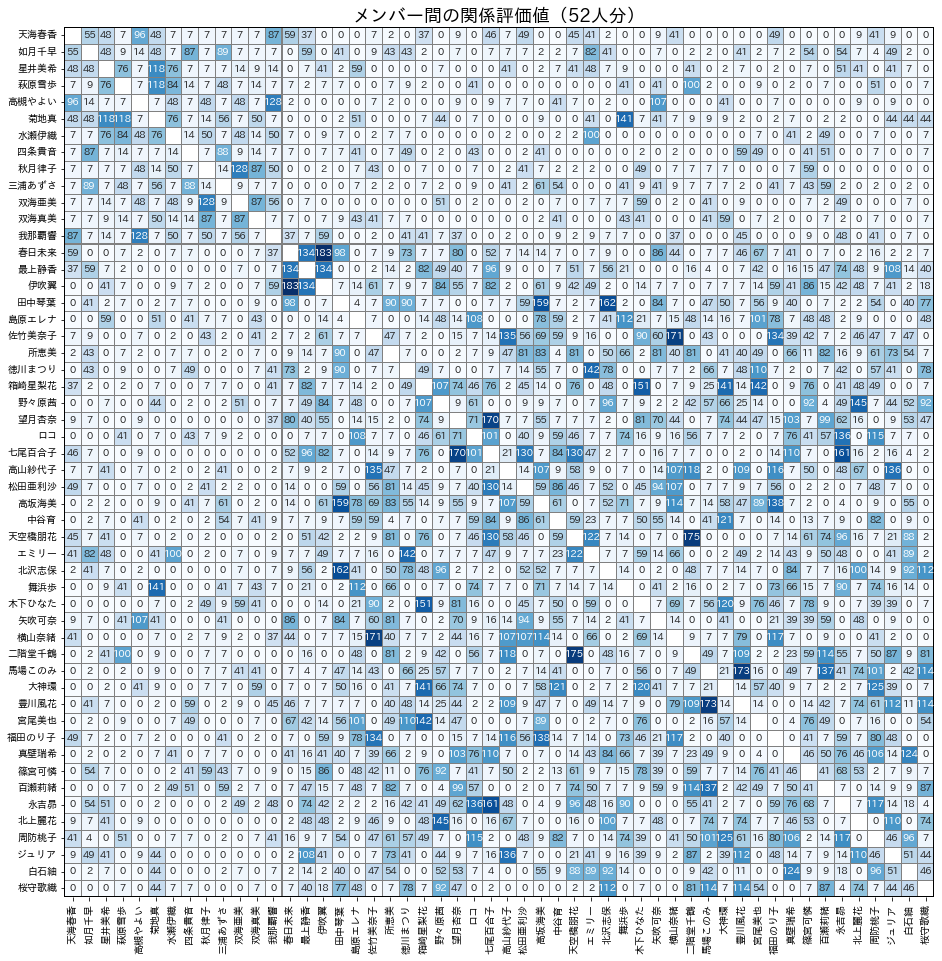

In [15]:
# 行・列名を日本語化したDataFrame
df_eval_j = df_eval.rename(columns=dict_name, index=dict_name)

# 作図の設定
fig, axes = plt.subplots(figsize=(16, 16))
fig.patch.set_facecolor('white')
sns.heatmap(df_eval_j, annot=True, fmt='.0f', cmap='Blues',linewidths=.5, linecolor="gray", cbar=False, square=True, ax=axes)
axes.set_title('メンバー間の関係評価値（52人分）', fontsize=18)
axes.axvline(x=13, linewidth=2, color='gray')
axes.axhline(y=13, linewidth=2, color='gray')
axes.axhline(y=0, color='k',linewidth=2)
axes.axhline(y=df_eval.shape[1], color='k',linewidth=2)
axes.axvline(x=0, color='k',linewidth=2)
axes.axvline(x=df_eval.shape[1], color='k',linewidth=2)

#### 関係評価値の分析

##### ミリオンスターズ間の関係評価値の要約統計量

In [16]:
# 要約統計量
df_eval_ms_j_dsc = df_eval_ms_j.describe().T

# 標準偏差が大きい順にソートして表示
display(df_eval_ms_j_dsc.sort_values('std', ascending=False))

,count,mean,std,min,25%,50%,75%,max
七尾百合子,38.0,37.049606,50.614335,0.0,1.873593,7.925555,69.760450,169.702164
高山紗代子,38.0,32.153871,45.235730,0.0,0.000000,7.250874,49.659117,135.863403
天空橋朋花,38.0,34.753454,44.016026,0.0,0.466033,11.628190,58.503623,174.715195
箱崎星梨花,38.0,36.206517,43.723051,0.0,1.864131,14.043117,49.200485,150.676012
田中琴葉,38.0,31.665251,43.669460,0.0,1.864131,6.963956,53.062572,162.435097
横山奈緒,38.0,30.003776,43.126054,0.0,1.809040,7.471532,43.382180,171.200146
二階堂千鶴,38.0,34.125523,42.971244,0.0,1.790677,9.298936,54.054989,174.715195
高坂海美,38.0,40.299108,42.684239,0.0,7.090850,14.296905,60.836261,159.191193
佐竹美奈子,38.0,33.044238,42.179971,0.0,1.898098,11.848848,47.000000,171.200146
春日未来,38.0,27.587216,42.057063,0.0,1.809040,6.963956,43.382180,182.584120


##### ミリオンスターズ間で関係評価値が0である相手の数

In [17]:
# 数が少ない順にソートして表示
display((df_eval_ms_j==0).sum().sort_values())

伊吹翼       3
篠宮可憐      4
北沢志保      5
百瀬莉緒      5
望月杏奈      5
豊川風花      5
ジュリア      6
大神環       6
周防桃子      6
永吉昴       6
所恵美       6
エミリー      6
高坂海美      6
真壁瑞希      6
中谷育       7
野々原茜      7
ロコ        7
田中琴葉      7
七尾百合子     7
馬場このみ     7
春日未来      8
佐竹美奈子     8
横山奈緒      9
二階堂千鶴     9
最上静香      9
松田亜利沙     9
北上麗花      9
箱崎星梨花     9
徳川まつり     9
矢吹可奈     10
天空橋朋花    10
島原エレナ    10
木下ひなた    11
福田のり子    11
舞浜歩      11
高山紗代子    11
桜守歌織     11
白石紬      12
宮尾美也     13
dtype: int64

例として、ロコに対する関係評価値が高いメンバー順に並べて表示してみる

In [18]:
# 計算上、1位はロコ自身となるのでDataFrameの1行目は除外している
pd.DataFrame.from_dict(dict_eval_two_comb['roco'], orient='index').sort_values('sum', ascending=False).iloc[1:].rename(index=dict_name)

,sum,LTP,LTH,LTD,LTF,TA,MTG,MS,TB,MTW,TC,なん笑,VOY@GER,MTS,ミリ女
永吉昴,136.105220,0.000000,0.000000,0.000000,0.000000,0.000000,74.057348,0.000000,0.0,62.047872,0.0,0.0,0.0,0.000000,0.0
周防桃子,115.300837,41.243488,0.000000,0.000000,0.000000,0.000000,74.057348,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
島原エレナ,108.129378,0.000000,41.413106,0.000000,59.244740,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,7.471532,0.0
七尾百合子,100.643266,0.000000,0.000000,0.000000,0.000000,38.595394,0.000000,0.000000,0.0,62.047872,0.0,0.0,0.0,0.000000,0.0
真壁瑞希,76.483360,0.000000,0.000000,0.000000,0.000000,0.000000,6.963956,0.000000,0.0,62.047872,0.0,0.0,0.0,7.471532,0.0
舞浜歩,74.057348,0.000000,0.000000,0.000000,0.000000,0.000000,74.057348,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
望月杏奈,70.942219,0.000000,0.000000,0.000000,7.030216,0.000000,0.000000,1.864131,0.0,62.047872,0.0,0.0,0.0,0.000000,0.0
野々原茜,60.633785,0.000000,0.000000,58.769654,0.000000,0.000000,0.000000,1.864131,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
中谷育,59.244740,0.000000,0.000000,0.000000,59.244740,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
百瀬莉緒,57.197955,0.000000,41.413106,1.790677,7.030216,0.000000,6.963956,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


### 各メンバーの「過去ユニット人数評価値」の確認

各メンバーが、MTG, MTWで何人組ユニットに属していたかを確認する。

人数の観点からも「新鮮な組み合わせ」を目指すため、各メンバーをなるべく過去に属したことのないn人組のユニットに割り振りたい。例えば、ロコはMTGで4人組、MTWで5人組だったので、今回はなるべく2人組か3人組に割り振りたい。

そのため、過去に属していたユニットの人数を確認する。

In [19]:
# チェックするCDの辞書を用意
## 対象のdisc_numのリストの辞書
dict_MTX_num = {
    'MTG': ['05', '06', '07', '08', '09', '10', '12', '13', '14', '15', '16', '17'],
    'MTW': ['02', '03','04', '05', '06', '07', '08', '09', '11', '12', '13', '14', '15', '16', '17', '18']
}

# シリーズごとの重みを用意
## MTGを0.99, MTWを1.0とする
dict_MTX_n_member_weight = {}
for i, one_MTX in enumerate(dict_MTX_num.keys()):
    dict_MTX_n_member_weight[one_MTX] = 0.99 ** (len(dict_MTX_num) - i - 1)

# 「何人組のユニットになったことがあるか」の辞書の初期化
dict_n_past_unit_member = {}
for one_person in list_name:
    dict_n_past_unit_member[one_person] = {}
    for one_n_unit_member in dict_ms_unit_num.keys():
        dict_n_past_unit_member[one_person][one_n_unit_member] = 0

# カウント
for one_series in ml_data['series_list']:
    if one_series['series_abbr'] not in dict_MTX_num.keys():
        continue
    for one_disc in one_series['disc_list']:
        if one_disc['disc_number'] not in dict_MTX_num[one_series['series_abbr']]:
            continue
        for one_person in one_disc['disc_member_list']:
            dict_n_past_unit_member[one_person][len(one_disc['disc_member_list'])] \
                += dict_MTX_n_member_weight[one_series['series_abbr']]

print('# 過去ユニット人数数評価値')
df_weight_past_unit_member = pd.DataFrame.from_dict(dict_n_past_unit_member, orient='index').rename(index=dict_name)
display(df_weight_past_unit_member)

# 過去ユニット人数数評価値


,2,3,4,5
天海春香,0.00,1.00,0.00,0.00
如月千早,0.00,1.00,0.00,0.00
星井美希,0.00,0.00,1.00,0.00
萩原雪歩,0.00,0.00,1.00,0.00
高槻やよい,0.00,1.00,0.00,0.00
菊地真,0.00,0.00,1.00,0.00
水瀬伊織,0.00,0.00,1.00,0.00
四条貴音,0.00,1.00,0.00,0.00
秋月律子,0.00,1.00,0.00,0.00
三浦あずさ,0.00,1.00,0.00,0.00


## タブーサーチを用いたMTXシリーズの組み合わせ作成

### 全探索する場合の組み合わせ数の確認

In [20]:
# 組み合わせ未決定の人数の初期値
n_ms_rest = n_all_ms

# 全組み合わせ数の初期値
n_all_comb = 1

# n人組のnについてループ
for one_n_member in dict_ms_unit_num.keys():
    # n人組の各ユニットについてループ
    for unit_id in range(dict_ms_unit_num[one_n_member]):
        # 現時点での全組み合わせ数に、「ユニット未決定のメンバーの中から着目しているユニットのメンバーを選出する時の組み合わせ数」を掛ける
        n_all_comb *= scipy.special.comb(n_ms_rest, one_n_member, exact=True)
        # 組み合わせ未決定の人数を減らす
        n_ms_rest -= one_n_member
    
    # 同じnのn人組ユニット同士の生成順は関係ないので、n人組ユニット数の階乗で割る
    n_all_comb /= scipy.special.factorial(dict_ms_unit_num[one_n_member], exact=True)


print('全組み合わせ数：{:.0f}'.format(n_all_comb))

全組み合わせ数：14298488868238422216189113532416


### 作成するユニットの識別子

n人組ユニットのm個目を(n, m)という識別子で表す(m=0, 1, ...)。

In [21]:
# ユニット識別子のリスト
list_unit_id = []
for n_member, n_unit_with_n_member in dict_ms_unit_num.items():
    for i in range(n_unit_with_n_member):
        list_unit_id.append((n_member, i))

print('# ユニット識別子のリスト')
print(list_unit_id)

# ユニット識別子のリスト
[(2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0)]


### 初期解の生成

In [22]:
# 初期解用のidリストを作成
## 要素は、「何人組ユニットの、何個目ユニットの、何番目の位置か」という識別子を表す辞書。
## この1要素が1人のメンバーと対応する。
list_id_for_init_sol = []

# ユニット識別子視点の辞書も作る
## こちらは、キーを(n, m)、値をメンバー名前のリスト（リスト順は位置に対応）とする辞書
dict_unit_key = {}

# n人組についてのループ
for one_n_unit_member in dict_ms_unit_num.keys():
    # n人組のユニットm個についてのループ
    for one_unit_number in range(dict_ms_unit_num[one_n_unit_member]):
        # 各ユニットの所属メンバーの人数分ループ
        for one_position in range(one_n_unit_member):
            # ある1人のメンバーと対応する識別子1つをリストに追加
            list_id_for_init_sol.append(
                {
                    'n_unit_member': one_n_unit_member,
                    'unit_id': one_unit_number,
                    'position': one_position
                }
            )
        
        # ユニット識別子視点の辞書の初期化
        dict_unit_key[(one_n_unit_member, one_unit_number)] = ['DUMMY'] * one_n_unit_member

# 識別子リストをシャッフル
list_id_for_init_sol_shuffule = random.sample(list_id_for_init_sol, len(list_id_for_init_sol))

# 初期解
## シャッフルした識別子を39人に割り当て、組み合わせの初期解とする。
dict_init_sol = dict(zip(list_ms_name, list_id_for_init_sol_shuffule))

# 初期解を、識別子順にソートする
dict_init_sol_sort = sorted(dict_init_sol.items(), key=lambda x: (x[1]['n_unit_member'], x[1]['unit_id'], x[1]['position']))

# 初期解のユニット識別子視点の辞書
for one_person, op_id in dict_init_sol.items():
    dict_unit_key[(op_id['n_unit_member'], op_id['unit_id'])][op_id['position']] = one_person

print('# メンバー視点の初期解')
pprint.pprint(dict_init_sol, sort_dicts=False)

print('# ユニット識別子視点の初期解')
pprint.pprint(dict_unit_key, sort_dicts=False)

# メンバー視点の初期解
{'mirai': {'n_unit_member': 3, 'unit_id': 3, 'position': 0},
 'shizuka': {'n_unit_member': 4, 'unit_id': 0, 'position': 1},
 'tsubasa': {'n_unit_member': 3, 'unit_id': 0, 'position': 0},
 'kotoha': {'n_unit_member': 4, 'unit_id': 1, 'position': 3},
 'elena': {'n_unit_member': 4, 'unit_id': 3, 'position': 0},
 'minako': {'n_unit_member': 3, 'unit_id': 1, 'position': 0},
 'megumi': {'n_unit_member': 2, 'unit_id': 2, 'position': 1},
 'matsuri': {'n_unit_member': 2, 'unit_id': 2, 'position': 0},
 'serika': {'n_unit_member': 2, 'unit_id': 0, 'position': 0},
 'akane': {'n_unit_member': 3, 'unit_id': 2, 'position': 0},
 'anna': {'n_unit_member': 3, 'unit_id': 3, 'position': 2},
 'roco': {'n_unit_member': 4, 'unit_id': 3, 'position': 3},
 'yuriko': {'n_unit_member': 5, 'unit_id': 0, 'position': 1},
 'sayoko': {'n_unit_member': 4, 'unit_id': 1, 'position': 2},
 'arisa': {'n_unit_member': 2, 'unit_id': 0, 'position': 1},
 'umi': {'n_unit_member': 3, 'unit_id': 0, 'position': 1},
 'i

### タブーサーチに必要な関数群

#### 解の形式を変換する関数

解（ある1つの「39人→12ユニット」の組み合わせパターン）の表現方法には、

1. メンバーの名前をキー、そのメンバーのポジション識別子を値とする辞書
1. ユニット識別子をキー、そのユニットに属するメンバーのリスト（順番付き）を値とする辞書

とする2つの表現形式があり、これらは1対1で対応する。

近傍解生成には1.の形式が使いやすいが、解の評価や人間による解の確認は2.の形式が分かりやすい。

よって、1.を2.に変換する関数を用意する。

In [23]:
## 入力：「名前をキー、ポジション識別子の辞書を値」とする辞書と、ユニット識別子（タプル）のリスト
## 出力：「ユニット識別子のタプルをキー、名前のリストを値」とする辞書
def mk_sol_id_from_sol_name(dict_sol_name, list_unit_id):
    
    # 出力する辞書
    dict_sol_id = {}
    # 初期化
    for one_unit_number in list_unit_id:
        dict_sol_id[one_unit_number] = ['DUMMY'] * one_unit_number[0]
    
    # 入力の辞書の各要素を出力の辞書の対応する要素に格納する
    for one_name in dict_sol_name.keys():
        dict_sol_id[(dict_sol_name[one_name]['n_unit_member'], dict_sol_name[one_name]['unit_id'])][dict_sol_name[one_name]['position']] = one_name

    return dict_sol_id

##### 動作確認

In [24]:
print('# 変換前')
pprint.pprint(dict_init_sol, sort_dicts=False)

# 変換
dict_sol_id_tmp = mk_sol_id_from_sol_name(dict_init_sol, list_unit_id)

print('# 変換後')
pprint.pprint(dict_sol_id_tmp, sort_dicts=False)

# 変換前
{'mirai': {'n_unit_member': 3, 'unit_id': 3, 'position': 0},
 'shizuka': {'n_unit_member': 4, 'unit_id': 0, 'position': 1},
 'tsubasa': {'n_unit_member': 3, 'unit_id': 0, 'position': 0},
 'kotoha': {'n_unit_member': 4, 'unit_id': 1, 'position': 3},
 'elena': {'n_unit_member': 4, 'unit_id': 3, 'position': 0},
 'minako': {'n_unit_member': 3, 'unit_id': 1, 'position': 0},
 'megumi': {'n_unit_member': 2, 'unit_id': 2, 'position': 1},
 'matsuri': {'n_unit_member': 2, 'unit_id': 2, 'position': 0},
 'serika': {'n_unit_member': 2, 'unit_id': 0, 'position': 0},
 'akane': {'n_unit_member': 3, 'unit_id': 2, 'position': 0},
 'anna': {'n_unit_member': 3, 'unit_id': 3, 'position': 2},
 'roco': {'n_unit_member': 4, 'unit_id': 3, 'position': 3},
 'yuriko': {'n_unit_member': 5, 'unit_id': 0, 'position': 1},
 'sayoko': {'n_unit_member': 4, 'unit_id': 1, 'position': 2},
 'arisa': {'n_unit_member': 2, 'unit_id': 0, 'position': 1},
 'umi': {'n_unit_member': 3, 'unit_id': 0, 'position': 1},
 'iku': {'

#### 

#### 「ユニット識別子をキーとする辞書」と「メンバーのリスト」と「関係評価値の辞書」から、「メンバー名をキー、そのユニットだった時の個人関係ペナルティ値を値とする辞書」を出力する関数

各メンバーにつき1つの個人関係ペナルティ値を計算する。1つの組み合わせに対する関係ペナルティ値は、その合計値とする。

In [25]:
## 入力：「ユニット識別子のタプルをキー、メンバー名のリストを値」とする辞書、メンバー名のリスト、関係評価値の辞書
## 出力：「メンバー名をキー、そのユニットだった時の個人関係ペナルティ値」とする辞書
def check_comb_eval_sol_id(dict_sol_id, list_name, dict_eval_sum_only, weight=1.0):
    
    # 個人関係ペナルティ値の辞書の初期化（初期値0）
    dict_comb_eval = dict(zip(list_name, [0 for _ in list_name]))
    
    # ユニット識別子をキーとする解の辞書のキーでループ
    for one_unit_number in dict_sol_id.keys():
        # もしユニットの人数が2人より少ない場合、そのユニットに属するメンバーの個人関係ペナルティ値はスキップ
        if len(dict_sol_id[one_unit_number]) < 2:
            continue
        # 個人関係ペナルティ値を求めたいメンバーについてループ
        for name_A in dict_sol_id[one_unit_number]:
            # 着目しているメンバーと同じユニットに属するメンバーについてループ
            for name_B in dict_sol_id[one_unit_number]:
                # 自身との関係評価値は集計対象外
                if name_A == name_B:
                    continue
                # 着目しているメンバーと同じユニットに属しているメンバー間の関係評価値を合計する
                dict_comb_eval[name_A] += dict_eval_sum_only[name_A][name_B]
            # 自分以外のユニットメンバー数で割り、重みを掛け、個人関係ペナルティ値とする
            dict_comb_eval[name_A] /= (len(dict_sol_id[one_unit_number]) - 1) * weight
    
    return dict_comb_eval

##### 動作確認

In [26]:
dict_comb_eval_tmp = check_comb_eval_sol_id(dict_sol_id_tmp, list_ms_name, dict_eval_sum_only, weight=1.0)
pprint.pprint(dict_comb_eval_tmp, sort_dicts=False)

{'mirai': 43.62116036457111,
 'shizuka': 38.415903251063376,
 'tsubasa': 31.216366425359993,
 'kotoha': 4.811829320711724,
 'elena': 75.75821006509894,
 'minako': 7.8924245113032505,
 'megumi': 7.471531942629769,
 'matsuri': 7.471531942629769,
 'serika': 45.42076774153908,
 'akane': 24.65589450273423,
 'anna': 43.654290602110244,
 'roco': 61.32580105475598,
 'yuriko': 9.870636358972218,
 'sayoko': 47.60911977156726,
 'arisa': 45.42076774153908,
 'umi': 56.30653960003174,
 'iku': 6.9970862570445345,
 'tomoka': 50.45110839721028,
 'emily': 8.82448985921024,
 'shiho': 26.954303870485724,
 'ayumu': 64.57005880872379,
 'hinata': 7.471531942629769,
 'kana': 19.519484970677677,
 'nao': 7.107415119056061,
 'chizuru': 46.242268159862775,
 'konomi': 20.382220106095026,
 'tamaki': 0.9320653479069899,
 'fuka': 5.408721490217535,
 'miya': 13.855827283603576,
 'noriko': 19.589884700767715,
 'mizuki': 7.471531942629769,
 'karen': 25.823634803632277,
 'rio': 5.445822687311725,
 'subaru': 44.1499606682

#### 「ユニット識別子をキーとする解の辞書」と「メンバーのリスト」と「過去ユニット人数評価値の辞書」から、「メンバー名をキー、そのユニットだった時の個人過去ユニット人数ペナルティ値を値とする辞書」を出力する関数

各メンバーにつき1つの個人過去ユニット人数ペナルティ値を計算する。1つの組み合わせに対する過去ユニット人数ペナルティ値は、その合計値とする。

In [27]:
# 入力：「ユニット識別子のタプルをキー、メンバー名のリストを値」とする辞書、メンバー名のリスト、過去ユニット人数評価値の辞書
# 出力：「メンバー名をキー、そのユニットだった時の個人過去ユニット人数ペナルティ値を値」とする辞書
def check_past_belonged_eval_sol_id(dict_sol_id, list_name, dict_n_past_unit_member, weight=1.0):
    
    # 個人過去ユニット人数ペナルティ値の辞書の初期化（初期値0）
    dict_past_belonged_eval = dict(zip(list_name, [0 for _ in list_name]))
    
    # ユニットidをキーとした解の辞書のキーでループ
    for one_unit_number in dict_sol_id.keys():
        for name in dict_sol_id[one_unit_number]:
            dict_past_belonged_eval[name] = dict_n_past_unit_member[name][one_unit_number[0]] * weight
    
    return dict_past_belonged_eval

##### 動作確認

In [28]:
check_past_belonged_eval_sol_id(dict_sol_id_tmp, list_ms_name, dict_n_past_unit_member)

{'mirai': 1.99,
 'shizuka': 0.0,
 'tsubasa': 1.99,
 'kotoha': 1.0,
 'elena': 1.0,
 'minako': 0.0,
 'megumi': 0.0,
 'matsuri': 0.99,
 'serika': 0.0,
 'akane': 0.99,
 'anna': 0.0,
 'roco': 0.99,
 'yuriko': 1.0,
 'sayoko': 1.0,
 'arisa': 0.0,
 'umi': 0.0,
 'iku': 1.99,
 'tomoka': 0.99,
 'emily': 1.0,
 'shiho': 0.99,
 'ayumu': 1.99,
 'hinata': 0.0,
 'kana': 0.0,
 'nao': 0.99,
 'chizuru': 0.0,
 'konomi': 0.0,
 'tamaki': 1.0,
 'fuka': 1.99,
 'miya': 1.0,
 'noriko': 1.0,
 'mizuki': 0.0,
 'karen': 1.0,
 'rio': 0.99,
 'subaru': 0.99,
 'reika': 0.0,
 'momoko': 1.0,
 'julia': 1.0,
 'tsumugi': 0.0,
 'kaori': 1.99}

#### 解の評価に使用するペナルティ値出力関数のリスト

各要素は、

- ペナルティ値出力関数名
- 関数オブジェクト
- その関数の計算に必要な評価値の辞書のリスト
- その関数に対する重み

を要素として持つ辞書とする。

In [29]:
# 参照するペナルティ値出力関数のリスト
list_dict_check_func = [
    {'name': 'comb_eval', 'func': check_comb_eval_sol_id, 'list_need_eval_dict': [dict_eval_sum_only], 'weight': 1.0},
    {'name': 'past_belonged_eval', 'func': check_past_belonged_eval_sol_id, 'list_need_eval_dict': [dict_n_past_unit_member], 'weight': 1.0}
]

#### 「ユニット識別子をキーとする解の辞書」と「メンバーのリスト」と「解の評価に使用するペナルティ値出力関数のリスト」から、キーを「メンバー名」、値を「そのメンバーに対する各ペナルティ値（とその合計値）の辞書」とする辞書を作成する関数

In [30]:
def mk_dict_all_eval(dict_sol_id, list_name, list_dict_check_func):

    # 初期化（合計の初期値0）
    dict_all_eval = dict(zip(list_name, [{'sum': 0} for _ in list_name]))

    for one_check in list_dict_check_func:
        dict_one_penalty = one_check['func'](dict_sol_id, list_ms_name, *one_check['list_need_eval_dict'], weight=one_check['weight'])

        for one_name in dict_all_eval.keys():
            dict_all_eval[one_name][one_check['name']] = dict_one_penalty[one_name]
            dict_all_eval[one_name]['sum'] += dict_one_penalty[one_name]
    
    return dict_all_eval

##### 動作確認

In [31]:
dict_all_eval_tmp = mk_dict_all_eval(dict_sol_id_tmp, list_ms_name, list_dict_check_func)
pprint.pprint(dict_all_eval_tmp, sort_dicts=False)

{'mirai': {'sum': 45.61116036457111,
           'comb_eval': 43.62116036457111,
           'past_belonged_eval': 1.99},
 'shizuka': {'sum': 38.415903251063376,
             'comb_eval': 38.415903251063376,
             'past_belonged_eval': 0.0},
 'tsubasa': {'sum': 33.206366425359995,
             'comb_eval': 31.216366425359993,
             'past_belonged_eval': 1.99},
 'kotoha': {'sum': 5.811829320711724,
            'comb_eval': 4.811829320711724,
            'past_belonged_eval': 1.0},
 'elena': {'sum': 76.75821006509894,
           'comb_eval': 75.75821006509894,
           'past_belonged_eval': 1.0},
 'minako': {'sum': 7.8924245113032505,
            'comb_eval': 7.8924245113032505,
            'past_belonged_eval': 0.0},
 'megumi': {'sum': 7.471531942629769,
            'comb_eval': 7.471531942629769,
            'past_belonged_eval': 0.0},
 'matsuri': {'sum': 8.461531942629769,
             'comb_eval': 7.471531942629769,
             'past_belonged_eval': 0.99},
 'serika': {

# タブーサーチ

### タブーサーチを構成する関数群

#### 入力を「メンバー名をキーとする1つの解を表す辞書」、「ユニット識別子のリスト」、「その解に対するペナルティ値の辞書」、出力を「メンバー名をキーとする、入力解の1つの近傍解を表す辞書」とする関数

入力解のメンバー2人の組み合わせ内識別子を入れ替え、近傍解とする。

1人目は、入力解におけるペナルティ値が大きいほど大きくなるように設定された選択確率に応じて全メンバーからランダムに選択する。

2人目は、1人目が属するユニット以外のユニットのメンバーの中から、等確率でランダムに選択する。

In [32]:
def mk_nh(dict_sol_name, list_unit_id, dict_all_eval):
    
    # 近傍解格納変数（入力解のコピーで初期化）
    dict_sol_name_nh = copy.deepcopy(dict_sol_name)
    
    # キーがユニット識別子である解表現に変換
    dict_sol_id = mk_sol_id_from_sol_name(dict_sol_name, list_unit_id)

    # 入れ替え1人目の選択
    ## ルーレット選択用のarray。長さはメンバー数。ペナルティ値の大きさに応じた選択確率を格納する。
    array_rate = np.asarray([dict_all_eval[k]['sum'] for k in dict_all_eval.keys()])
    array_rate /= array_rate.sum()
    ## 入れ替え1人目を選択し、名前を記録
    change_name_A = np.random.choice(list(dict_sol_name.keys()), p=array_rate)

    # 入れ替え2人目の選択
    ## 一度、全員の名前をリストにする
    list_for_name_B = list(dict_sol_name.keys())
    ## 1人目が属しているユニットのメンバーを2人目選択リストから除外
    for one_name in dict_sol_id[(dict_sol_name[change_name_A]['n_unit_member'], dict_sol_name[change_name_A]['unit_id'])]:
        list_for_name_B.remove(one_name)
    ## リストから等確率でランダムに選択
    change_name_B = np.random.choice(list_for_name_B)

    # 1人目と2人目のユニット内識別子を入れ替える
    dict_sol_name_nh[change_name_A], dict_sol_name_nh[change_name_B] = dict_sol_name_nh[change_name_B], dict_sol_name_nh[change_name_A]

    return dict_sol_name_nh

##### 動作確認

In [33]:
mk_nh(dict_init_sol, list_unit_id, dict_all_eval_tmp)

{'mirai': {'n_unit_member': 3, 'unit_id': 3, 'position': 0},
 'shizuka': {'n_unit_member': 4, 'unit_id': 0, 'position': 1},
 'tsubasa': {'n_unit_member': 3, 'unit_id': 0, 'position': 0},
 'kotoha': {'n_unit_member': 4, 'unit_id': 1, 'position': 3},
 'elena': {'n_unit_member': 4, 'unit_id': 3, 'position': 0},
 'minako': {'n_unit_member': 4, 'unit_id': 2, 'position': 0},
 'megumi': {'n_unit_member': 2, 'unit_id': 2, 'position': 1},
 'matsuri': {'n_unit_member': 2, 'unit_id': 2, 'position': 0},
 'serika': {'n_unit_member': 2, 'unit_id': 0, 'position': 0},
 'akane': {'n_unit_member': 3, 'unit_id': 2, 'position': 0},
 'anna': {'n_unit_member': 3, 'unit_id': 3, 'position': 2},
 'roco': {'n_unit_member': 4, 'unit_id': 3, 'position': 3},
 'yuriko': {'n_unit_member': 5, 'unit_id': 0, 'position': 1},
 'sayoko': {'n_unit_member': 4, 'unit_id': 1, 'position': 2},
 'arisa': {'n_unit_member': 2, 'unit_id': 0, 'position': 1},
 'umi': {'n_unit_member': 3, 'unit_id': 0, 'position': 1},
 'iku': {'n_unit

#### 入力を「メンバーごとのペナルティ値の辞書」、出力を「各メンバーのペナルティ値の合計（＝解の評価値）」とする関数

In [34]:
def calc_eval_value_from_dict_eval(dict_all_eval):
    
    # 解の評価値を0で初期化
    eval_value = 0
    
    # 各メンバーに対するペナルティ値を合計
    for one_name in dict_all_eval.keys():
        eval_value += dict_all_eval[one_name]['sum']
    
    return eval_value

##### 動作確認

In [35]:
calc_eval_value_from_dict_eval(dict_all_eval_tmp)

1140.6603801180522

##### サンプルデータの個人ペナルティ値と組み合わせ評価値の確認

In [36]:
print('# 組み合わせ')
for one_id in dict_sol_id_tmp.keys():
    print(one_id, [dict_name[name] for name in dict_sol_id_tmp[one_id]])

print('')
print('# 個人ペナルティ値')
for one_name in dict_all_eval_tmp.keys():
    print('{:<6}\t... {:3.2f}（関係：{:3.2f}、過去ユニット：{}）'.format(dict_name[one_name], dict_all_eval_tmp[one_name]['sum'], dict_all_eval_tmp[one_name]['comb_eval'], dict_all_eval_tmp[one_name]['past_belonged_eval']))

print('')
print('# 組み合わせ評価値：{}'.format(calc_eval_value_from_dict_eval(dict_all_eval_tmp)))


# 組み合わせ
(2, 0) ['箱崎星梨花', '松田亜利沙']
(2, 1) ['真壁瑞希', '木下ひなた']
(2, 2) ['徳川まつり', '所恵美']
(3, 0) ['伊吹翼', '高坂海美', '北沢志保']
(3, 1) ['佐竹美奈子', '大神環', 'エミリー']
(3, 2) ['野々原茜', '周防桃子', '二階堂千鶴']
(3, 3) ['春日未来', '中谷育', '望月杏奈']
(4, 0) ['永吉昴', '最上静香', '宮尾美也', '福田のり子']
(4, 1) ['百瀬莉緒', 'ジュリア', '高山紗代子', '田中琴葉']
(4, 2) ['白石紬', '桜守歌織', '天空橋朋花', '篠宮可憐']
(4, 3) ['島原エレナ', '豊川風花', '舞浜歩', 'ロコ']
(5, 0) ['馬場このみ', '七尾百合子', '横山奈緒', '矢吹可奈', '北上麗花']

# 個人ペナルティ値
春日未来  	... 45.61（関係：43.62、過去ユニット：1.99）
最上静香  	... 38.42（関係：38.42、過去ユニット：0.0）
伊吹翼   	... 33.21（関係：31.22、過去ユニット：1.99）
田中琴葉  	... 5.81（関係：4.81、過去ユニット：1.0）
島原エレナ 	... 76.76（関係：75.76、過去ユニット：1.0）
佐竹美奈子 	... 7.89（関係：7.89、過去ユニット：0.0）
所恵美   	... 7.47（関係：7.47、過去ユニット：0.0）
徳川まつり 	... 8.46（関係：7.47、過去ユニット：0.99）
箱崎星梨花 	... 45.42（関係：45.42、過去ユニット：0.0）
野々原茜  	... 25.65（関係：24.66、過去ユニット：0.99）
望月杏奈  	... 43.65（関係：43.65、過去ユニット：0.0）
ロコ    	... 62.32（関係：61.33、過去ユニット：0.99）
七尾百合子 	... 10.87（関係：9.87、過去ユニット：1.0）
高山紗代子 	... 48.61（関係：47.61、過去ユニット：1.0）
松田亜利沙 	... 45.42（関係：45.42、過去ユニット：0.0）
高坂海

### タブーサーチのメイン関数

入力を、

- 初期解
- ユニット識別子のリスト
- 解の評価に使用するペナルティ値出力関数のリスト
- タブーリストのサイズ
- 一度のループで生成する近傍解の数
- 最大ループ数

出力を、

- ループ終了時点での最適解
    - メンバー名をキーとする、組み合わせを表す辞書
    - メンバーごとのペナルティ値の辞書
    - 評価値の推移
- ループ終了時点での現在解
    - メンバー名をキーとする、組み合わせを表す辞書
    - メンバーごとのペナルティ値の辞書
    - 評価値の推移

とする関数

In [37]:
def tabu_search(dict_init_sol, list_unit_id, list_dict_check_func, size_tabu_list=7, n_nh=8, max_loop=100):

    # ----- ここから初期解の評価、および現在解・最適解の初期設定 -----
    
    # 名前リストを作成
    list_name = list(dict_init_sol.keys())
    
    # 初期解を、ユニット識別子をキーとする解に変換
    dict_init_sol_id = mk_sol_id_from_sol_name(dict_init_sol, list_unit_id)
    
    # 初期解の評価値を取得
    dict_init_eval = mk_dict_all_eval(dict_init_sol_id, list_name, list_dict_check_func)
    
    # 1つの評価値を計算
    eval_value_init = calc_eval_value_from_dict_eval(dict_init_eval)

    # 現在解を初期解としておく
    dict_present_sol_and_eval = {'sol': copy.deepcopy(dict_init_sol), 'eval': {'eval_value': eval_value_init, 'dict_eval': copy.deepcopy(dict_init_eval)}}

    # 現時点での最適解も初期解としておく
    dict_best_sol_and_eval = {'sol': copy.deepcopy(dict_init_sol), 'eval': {'eval_value': eval_value_init, 'dict_eval': copy.deepcopy(dict_init_eval)}}

    # 評価値は毎回記録する。
    ## 現在解の評価値を記録するリスト（1つ目の値は初期解の評価値）
    list_present_eval = [eval_value_init]
    ## 現時点での最適解の評価値を記録するリスト（1つ目の値は初期解の評価値）
    list_best_eval = [eval_value_init]

    # タブーリストを用意
    ## 今回はリストの要素を「解→解の遷移」としている。
    tabu_list = []


    # ----- ここから近傍探索 -----

    # 近傍探索ループ
    ## 最大max_loop回。評価値が0になった時点で終了。
    for i in range(max_loop):

        # 現在の解から、要素数n_nhの「近傍解とその評価値の辞書」のリストを生成

        # 1回の近傍探索で作られるn_nh個の近傍解のうち、ベストのものを保存する辞書
        ## どんな評価値と比較しても相手が小さくなるように、評価値の初期値を正の無限大に設定
        dict_best_nh_sol_and_eval = {'sol': None, 'eval': {'eval_value': float('inf'), 'dict_eval': None}}
        
        # 1回の探索における近傍解生成ループ
        ## 1回の探索で作られる近傍解の数はn_nh個
        for _ in range(n_nh):
            
            # 1つの近傍解を生成
            dict_nh_sol = mk_nh(dict_present_sol_and_eval['sol'], list_unit_id, dict_present_sol_and_eval['eval']['dict_eval'])

            # 近傍解を、ユニット識別子をキーとする解に変換
            dict_nh_sol_id = mk_sol_id_from_sol_name(dict_nh_sol, list_unit_id)

            # 近傍解における各メンバーのペナルティ値の計算
            dict_nh_eval = mk_dict_all_eval(dict_nh_sol_id, list_name, list_dict_check_func)

            # 近傍解の評価値の計算
            eval_value_nh = calc_eval_value_from_dict_eval(dict_nh_eval)

            # もしこの近傍解の評価値が探索の中の今まで見てきた近傍解の評価値より小さかったら、1探索内の暫定1位（「現在の解」）として記録
            if eval_value_nh < dict_best_nh_sol_and_eval['eval']['eval_value']:
                dict_best_nh_sol_and_eval = {'sol': copy.deepcopy(dict_nh_sol), 'eval': {'eval_value': eval_value_nh, 'dict_eval': copy.deepcopy(dict_nh_eval)}}

        # 上記の近傍解生成ループによって、この回の近傍探索におけるベストの近傍解が決定した。
        ## もし、このベスト近傍解が、現時点の最適解より良い評価値の解だったら
        if dict_best_nh_sol_and_eval['eval']['eval_value'] < dict_best_sol_and_eval['eval']['eval_value']:
            # 現時点での最適解を、このベスト近傍解とする。
            dict_best_sol_and_eval = copy.deepcopy(dict_best_nh_sol_and_eval)
            
            # もし現在解→ベスト近傍解の操作がタブーリストに記載してあったら
            if [dict_present_sol_and_eval['sol'], dict_best_nh_sol_and_eval['sol']] in tabu_list:
                # 現在解→ベスト近傍解の記載をタブーリストの最新に持ってくる。
                ## 一度リストから削除して、
                tabu_list.remove([dict_present_sol_and_eval['sol'], dict_best_nh_sol_and_eval['sol']])
                ## 末尾に改めて追加
                tabu_list.append([dict_present_sol_and_eval['sol'], dict_best_nh_sol_and_eval['sol']])

            # 現在解も、このベスト近傍解とする。
            dict_present_sol_and_eval = copy.deepcopy(dict_best_nh_sol_and_eval)

        ## もしベスト近傍解が現時点の最適解より悪い評価値の解だったら
        else:
            # もし現在解→ベスト近傍解の操作がタブーリストに記載されていなかったら
            if [dict_present_sol_and_eval['sol'], dict_best_nh_sol_and_eval['sol']] not in tabu_list:
                # 現在解→ベスト近傍解の操作をタブーリストに記載し、
                tabu_list.append([dict_present_sol_and_eval['sol'], dict_best_nh_sol_and_eval['sol']])
                # 現在解をベスト近傍解にする
                dict_present_sol_and_eval = copy.deepcopy(dict_best_nh_sol_and_eval)
                # 記載によってタブーリストのサイズがsize_tabu_listを超えたら
                if size_tabu_list < len(tabu_list):
                    # 先頭の値（一番古い値）を削除する
                    tabu_list.pop(0)

        # 1回の近傍探索ごとに、現時点での最適解の評価値と現在解の評価値を記録
        list_best_eval.append(dict_best_sol_and_eval['eval']['eval_value'])
        list_present_eval.append(dict_present_sol_and_eval['eval']['eval_value'])

        print('# n={}... 現時点での最適解評価値:{}、現在解評価値:{}'.format(i, dict_best_sol_and_eval['eval']['eval_value'], dict_present_sol_and_eval['eval']['eval_value']))
        
        # 評価値が0の解が見つかった時点で探索終了
        if dict_best_sol_and_eval['eval']['eval_value']==0:
            print('# 評価値が0の解が見つかりました。探索を終了します。')
            break

    
    # ----- ここから出力データの整形 -----
    
    # 結果を格納する辞書
    dict_result = {
        'best': {
            'solution': dict_best_sol_and_eval['sol'], 
            'eval': dict_best_sol_and_eval['eval'], 
            'evolution': list_best_eval
        },
        'present': {
            'solution': dict_present_sol_and_eval['sol'],
            'eval': dict_present_sol_and_eval['eval'],
            'evolution': list_present_eval
        }
    }

    return dict_result 

### 実行

In [38]:
dict_opt_result = tabu_search(dict_init_sol, list_unit_id, list_dict_check_func, size_tabu_list=16, n_nh=256, max_loop=5000)

# n=0... 現時点での最適解評価値:951.3568075232424、現在解評価値:951.3568075232424
# n=1... 現時点での最適解評価値:778.3570564050403、現在解評価値:778.3570564050403
# n=2... 現時点での最適解評価値:641.0453677315821、現在解評価値:641.0453677315821
# n=3... 現時点での最適解評価値:470.08033692295567、現在解評価値:470.08033692295567
# n=4... 現時点での最適解評価値:367.83109120841766、現在解評価値:367.83109120841766
# n=5... 現時点での最適解評価値:304.3118234941305、現在解評価値:304.3118234941305
# n=6... 現時点での最適解評価値:250.03535449240943、現在解評価値:250.03535449240943
# n=7... 現時点での最適解評価値:214.49269143930883、現在解評価値:214.49269143930883
# n=8... 現時点での最適解評価値:198.62438822940578、現在解評価値:198.62438822940578
# n=9... 現時点での最適解評価値:180.04261032656896、現在解評価値:180.04261032656896
# n=10... 現時点での最適解評価値:173.18797055344504、現在解評価値:173.18797055344504
# n=11... 現時点での最適解評価値:157.5858674354554、現在解評価値:157.5858674354554
# n=12... 現時点での最適解評価値:151.9090564390663、現在解評価値:151.9090564390663
# n=13... 現時点での最適解評価値:149.66380111529466、現在解評価値:149.66380111529466
# n=14... 現時点での最適解評価値:147.68380111529464、現在解評価値:147.68380111529464
# n=15... 現時点での最適

# 結果

## 得られた最適解

In [39]:
# キーをユニット識別子とする解表現に変換
dict_best_sol_id = mk_sol_id_from_sol_name(dict_opt_result['best']['solution'], list_unit_id)

# 表示
for one_id in dict_best_sol_id.keys():
    print(one_id, [dict_name[name] for name in dict_best_sol_id[one_id]])

(2, 0) ['二階堂千鶴', '望月杏奈']
(2, 1) ['矢吹可奈', '箱崎星梨花']
(2, 2) ['周防桃子', '篠宮可憐']
(3, 0) ['馬場このみ', 'エミリー', '所恵美']
(3, 1) ['北上麗花', '高坂海美', '百瀬莉緒']
(3, 2) ['桜守歌織', '佐竹美奈子', '舞浜歩']
(3, 3) ['七尾百合子', '北沢志保', '木下ひなた']
(4, 0) ['宮尾美也', 'ジュリア', '真壁瑞希', '中谷育']
(4, 1) ['徳川まつり', '横山奈緒', '野々原茜', '天空橋朋花']
(4, 2) ['大神環', '高山紗代子', '白石紬', '伊吹翼']
(4, 3) ['永吉昴', '島原エレナ', '春日未来', '松田亜利沙']
(5, 0) ['豊川風花', '最上静香', '福田のり子', 'ロコ', '田中琴葉']


## 評価値の推移

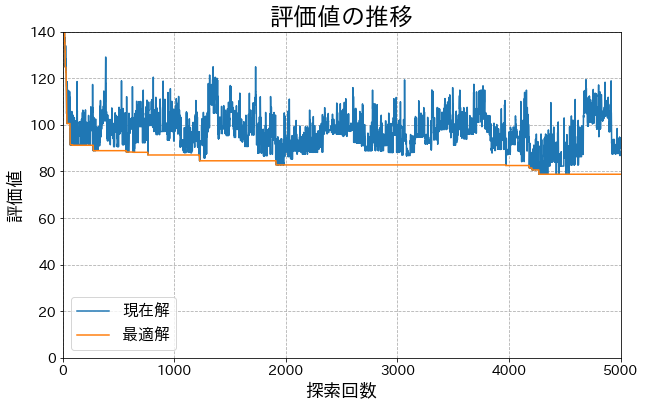

In [40]:
# 設定
fig, ax = plt.subplots(figsize=(10.0, 6.0))
fig.patch.set_facecolor('white')
ax.set_xlim([0, len(dict_opt_result['best']['evolution'])])
ax.set_ylim([0, 140])
ax.set_xlabel('探索回数', fontsize=18)
ax.set_ylabel('評価値', fontsize=18)
ax.set_title("評価値の推移", fontsize=24)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(ls='--')

# 表示
range_begin = 0
ax.plot(np.arange(len(dict_opt_result['present']['evolution']))[range_begin:], dict_opt_result['present']['evolution'][range_begin:], label='現在解')
ax.plot(np.arange(len(dict_opt_result['best']['evolution']))[range_begin:], dict_opt_result['best']['evolution'][range_begin:], label='最適解')
ax.legend(fontsize=16)

#### 最適解におけるペナルティ値が大きい順にメンバーを並べ替えて確認

In [41]:
# DataFrame化
df_penalty_best_sol = pd.DataFrame.from_dict(dict_opt_result['best']['eval']['dict_eval'], orient='index').sort_values('sum', ascending=False)

# 最適解におけるユニットメンバー数を列として追加
df_penalty_best_sol['n_unit_member'] = df_penalty_best_sol.index.map(lambda x: dict_opt_result['best']['solution'][x]['n_unit_member'])

# メンバー名を日本語化
df_penalty_best_sol = df_penalty_best_sol.rename(index=dict_name)

# 関係評価値の統計量を列として追加
df_penalty_best_sol = df_penalty_best_sol.merge(df_eval_ms_j_dsc.loc[:, ['mean', 'std', 'max']].add_prefix('dsc_'), left_index=True, right_index=True, how='left')

# 過去の所属ユニットメンバー数を列として追加
df_penalty_best_sol = df_penalty_best_sol.merge(df_weight_past_unit_member.add_prefix('w_'), left_index=True, right_index=True, how='left')

# 表示
display(df_penalty_best_sol)

,sum,comb_eval,past_belonged_eval,n_unit_member,dsc_mean,dsc_std,dsc_max,w_2,w_3,w_4,w_5
真壁瑞希,5.882993,5.882993,0.00,4,36.150978,35.939481,123.928040,0.00,0.99,0.00,1.00
ジュリア,5.664724,4.664724,1.00,4,31.924071,36.742203,135.863403,0.99,0.00,1.00,0.00
徳川まつり,5.596443,4.596443,1.00,4,27.281170,36.559030,142.497021,0.99,0.00,1.00,0.00
ロコ,4.946212,3.946212,1.00,5,32.061363,37.954378,136.105220,0.00,0.00,0.99,1.00
福田のり子,4.936212,3.946212,0.99,5,32.029512,41.092504,138.106752,0.00,0.00,1.00,0.99
松田亜利沙,4.596443,4.596443,0.00,4,29.424606,35.085654,130.218161,0.00,1.99,0.00,0.00
春日未来,4.596443,4.596443,0.00,4,27.587216,42.057063,182.584120,0.00,1.99,0.00,0.00
豊川風花,4.021895,4.021895,0.00,5,34.869935,41.989300,173.275836,0.00,0.00,1.99,0.00
田中琴葉,3.895001,3.895001,0.00,5,31.665251,43.669460,162.435097,0.00,0.99,1.00,0.00
最上静香,3.608872,3.608872,0.00,5,30.264902,38.058480,133.699482,0.99,1.00,0.00,0.00


#### 個人ペナルティ値とユニット人数の関係の可視化

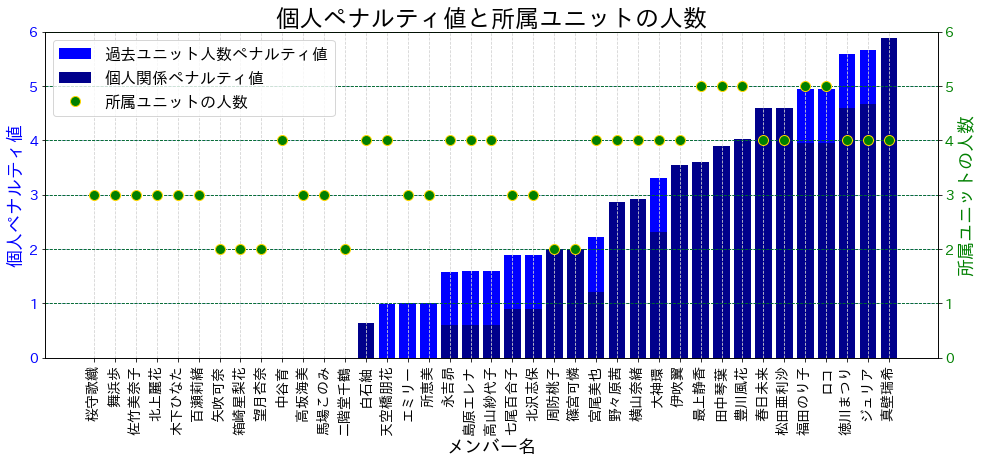

In [42]:
# 全体の設定
fig, ax1 = plt.subplots(figsize=(16.0, 6.0))
fig.patch.set_facecolor('white')
ax1.set_title('個人ペナルティ値と所属ユニットの人数', fontsize=24)
ax1.grid(ls='--', axis='x', color='lightgray')

# 個人ペナルティ値棒グラフの設定
ax1.set_xlabel('メンバー名', fontsize=18)
ax1.set_ylabel('個人ペナルティ値', fontsize=18, color='blue')
ax1.tick_params(axis='x', labelsize=14, labelrotation=90)
ax1.tick_params(axis='y', labelsize=14, labelcolor='blue')
ax1.grid(ls='--', axis='y', color='blue')
ylim_val = int(df_penalty_best_sol[['sum', 'n_unit_member']].max().max() + 1)
ax1.set_ylim([0, ylim_val])
ax1.invert_xaxis()

# 表示ループ用の準備
dict_for_label= {
    'comb_eval': '個人関係ペナルティ値',
    'past_belonged_eval': '過去ユニット人数ペナルティ値'
    }
list_lc = ['darkblue', 'blue']

# 個人ペナルティ値棒グラフの表示
for i in range(1, 1+2):
    ax1.bar(df_penalty_best_sol.index, df_penalty_best_sol.iloc[:, i], bottom=df_penalty_best_sol.iloc[:, 1:i].sum(axis=1), label=dict_for_label[df_penalty_best_sol.columns[i]], color=list_lc[i-1])

# ユニット人数プロットの設定
ax2 = ax1.twinx()
ax2.set_ylabel('所属ユニットの人数', fontsize=18, color='green')
ax2.tick_params(axis='y', labelsize=14, labelcolor='green')
ax2.grid(ls='--', axis='y',  color='green')
ax2.set_ylim([0, ylim_val])
## X軸の数字が必ず整数になるようにする
ax2.get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))

# ユニット人数プロットの表示
ax2.plot(df_penalty_best_sol.index, df_penalty_best_sol['n_unit_member'], linestyle='None', marker='o', color='green', markeredgecolor='gold', markersize=10, label='所属ユニットの人数')

# 凡例の設定
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1[::-1] + h2, l1[::-1] + l2, fontsize=16, loc='upper left')